Import Libraries

In [ ]:
import torch
import torchvision.transforms.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

Resize of Image

In [22]:
def resize_keep_aspect(img, size=224):
    #resize image using thumbnail(preserves aspect ratio)
    img.thumbnail((size, size))
    
    #pad to square
    new_img = Image.new("RGB", (size, size))
    # new_img.paste(img, (size - img.width / 2, size - img.height / 2))  
    new_img.paste(img, ((size-img.width) //2, (size-img.height) // 2))
    return new_img

Before Preprocessing: (224, 210)


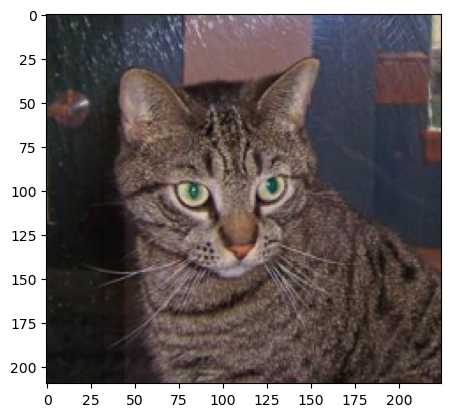

After Preprocessing: (224, 224)


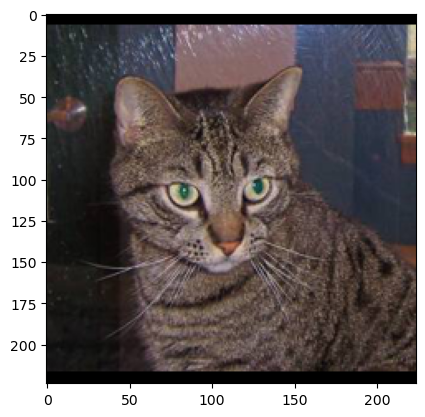

In [25]:
image = Image.open("PetImages/1.jpg")
resized_image = resize_keep_aspect(image, 224)
print(f"Before Preprocessing: {image.size}")
plt.imshow(image)
plt.show()
print(f"After Preprocessing: {resized_image.size}")
plt.imshow(resized_image)
plt.show()

Removing Noise in image

In [35]:
#Removing Noise in image
def gaussian_blur(img_tensor, kernel_size=5, sigma=1.0):
    blur = transforms.GaussianBlur(kernel_size=kernel_size, sigma=sigma)
    return blur(img_tensor)

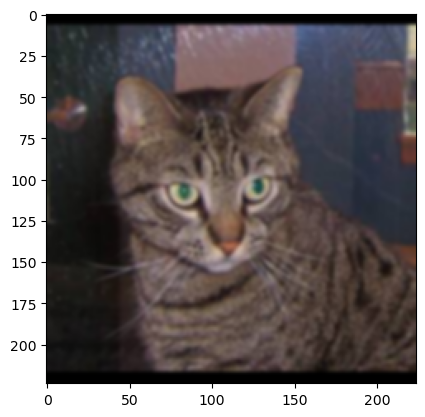

In [37]:
noise_reduction = gaussian_blur(resized_image, kernel_size=5, sigma=1.1)
plt.imshow(noise_reduction)
plt.show()

Auto Brightness contrast image

In [33]:
def auto_brightness_contrast(img_tensor, target_mean=0.5):
    # img_tensor: [C,H,W] in [0,1]
    mean = img_tensor.mean()
    img = img_tensor - mean + target_mean  # shift mean brightness

    # contrast normalization
    std = img.std()
    if std > 1e-6:
        img = (img - img.mean()) / std * 0.25 + target_mean

    img = torch.clamp(img, 0, 1)
    return img

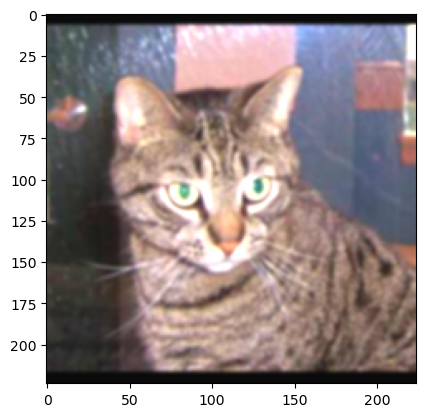

In [44]:
auto_brightnessed = auto_brightness_contrast(F.to_tensor(noise_reduction))
img_np = auto_brightnessed.permute(1, 2, 0).numpy()
img_np = np.clip(img_np, 0, 1)

plt.imshow(img_np)
plt.show()


Normalization

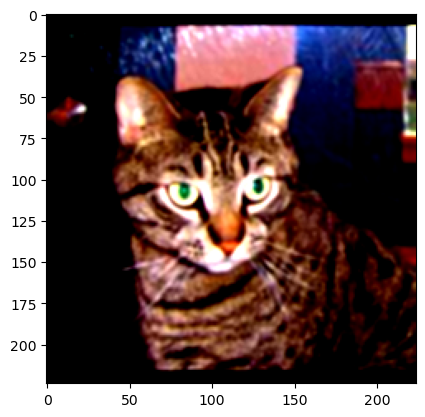

In [45]:
#Normalization
normalized = F.normalize(auto_brightnessed, mean=[0.5]*3, std=[0.5]*3)
img_np = normalized.permute(1, 2, 0).numpy()
img_np = np.clip(img_np, 0, 1)

plt.imshow(img_np)
plt.show()

Bulk Image Processing

In [ ]:
def preprocess_image(path, size=224):
    # load image
    img = Image.open(path).convert("RGB")

    # resize & pad
    img = resize_keep_aspect(img, size=size)

    # convert to tensor [0,1]
    img = F.to_tensor(img)

    # noise reduction
    img = gaussian_blur(img, kernel_size=5, sigma=1.1)

    # brightness + contrast correction
    img = auto_brightness_contrast(img, target_mean=0.5)

    # normalize for training
    img = F.normalize(img, mean=[0.5]*3, std=[0.5]*3)

    return img

Entire Pipeline for processing bulk images

In [50]:
import torch
import torchvision.transforms.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import os

# 1. Resize (keep aspect ratio) + pad to square
def resize_keep_aspect(img, size=224):
    #resize image using thumbnail(preserves aspect ratio)
    img.thumbnail((size, size))
    
    #pad to square
    new_img = Image.new("RGB", (size, size))
    # new_img.paste(img, (size - img.width / 2, size - img.height / 2))  
    new_img.paste(img, ((size-img.width) //2, (size-img.height) // 2))
    return new_img


# 2. Gaussian blur (noise reduction)
def gaussian_blur(img_tensor, kernel_size=5, sigma=1.0):
    blur = transforms.GaussianBlur(kernel_size=kernel_size, sigma=sigma)
    return blur(img_tensor)


# -----------------------------------------------------
# 3. Auto brightness + contrast correction
# -----------------------------------------------------
def auto_brightness_contrast(img_tensor, target_mean=0.5):
    mean = img_tensor.mean()
    img = img_tensor - mean + target_mean

    std = img.std()
    if std > 1e-6:
        img = (img - img.mean()) / std * 0.25 + target_mean

    return torch.clamp(img, 0, 1)


# -----------------------------------------------------
# 4. Preprocess a single image file
# -----------------------------------------------------
def preprocess_image(path, size=224):
    # load image
    img = Image.open(path).convert("RGB")

    # resize & pad
    img = resize_keep_aspect(img, size=size)

    # convert to tensor [0,1]
    img = F.to_tensor(img)

    # noise reduction
    img = gaussian_blur(img, kernel_size=5, sigma=1.1)

    # brightness + contrast correction
    img = auto_brightness_contrast(img, target_mean=0.5)

    # normalize for training
    img = F.normalize(img, mean=[0.5]*3, std=[0.5]*3)

    return img


# -----------------------------------------------------
# 5. Preprocess ENTIRE folder
# -----------------------------------------------------
def preprocess_folder(folder_path, size=224):
    processed = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            full_path = os.path.join(folder_path, filename)
            img_tensor = preprocess_image(full_path, size=size)
            processed.append(img_tensor)

    return processed



In [51]:
petImages = preprocess_folder("PetImages", 224)
print(len(petImages))
print(petImages[0].shape)   # -> torch.Size([3, 224, 224])


12500
torch.Size([3, 224, 224])
